# Finishing Up

## Review

We've used sub-graph and map-reduce and run a set of interviews with experts across user-defined information sources in parallel.

We append the takes from these interviews to a key / channel in our `OverallState`.

## Goals

Now, let's all some finishing touches: we'll connect our take-bot to Slack and add human-in-the-loop to review before approval to publish!

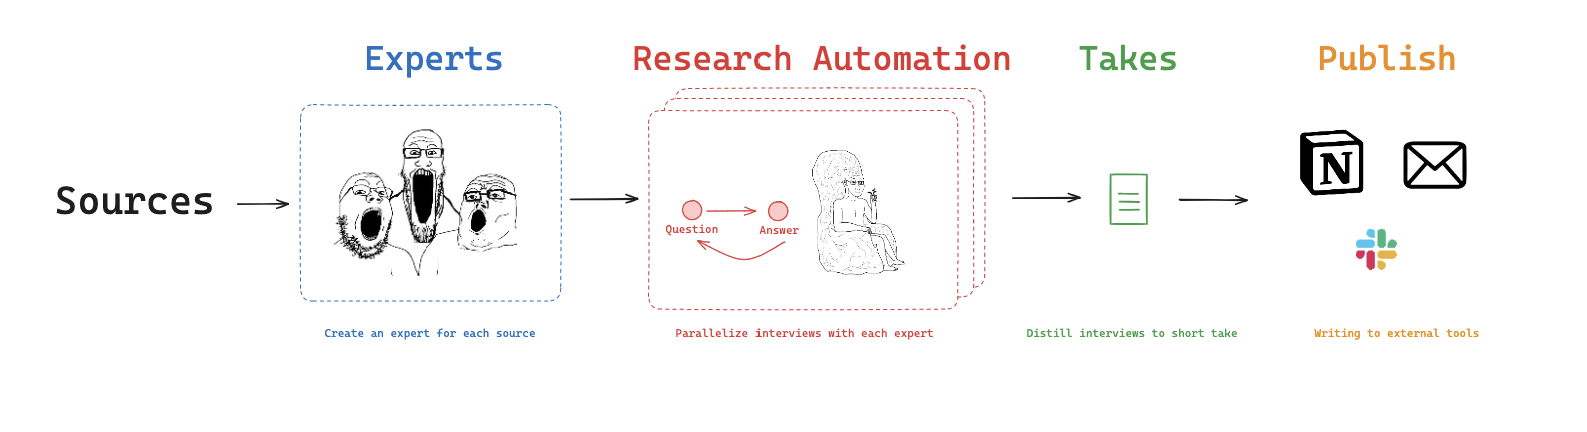

In [ ]:
%%capture --no-stderr
%pip install --quiet -U sqlite3 langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Gather expert sources

Now, we'll use the same helper functions to gather information from Reddit.

In [2]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    ''' Get comments from top posts in a particular subreddit '''

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"URL: {post.url}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

def get_reddit_post(url,
                   number_of_comments):
    
    ''' Get reddit post comments '''

    # Fetch the submission
    post = reddit.submission(url=url)
    
    # Load the comments
    post.comments.replace_more(limit=None) # Flatten the comment tree
    comments = post.comments.list()

    # Initialize an empty string to store the output
    reddit_expert_context = ""
    reddit_expert_context += f"Title: {post.title}\n"
    reddit_expert_context += f"URL: {post.url}   \n"
    reddit_expert_context += f"Post: {post.selftext}\n"

    # Get the specified number of top comments
    for i, comment in enumerate(post.comments[:number_of_comments]):
        reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
        reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

## Build graph

### Parameters and LLM

In this example, we created Slack webhook for writing the takes.

In [3]:
import os

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0) 
max_num_turns = 2
slack_bot_url = os.getenv('LANCE_BOT_SLACK_URL')

### State

In [4]:
import operator

from typing_extensions import TypedDict, List, Annotated

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from langgraph.graph import MessagesState

class Expert(BaseModel):
    name: str = Field(
        description="Name of the expert.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the expert.",
    )
    context: SystemMessage = Field(
        description="Instructions used by the expert.",
    )

    def answer(self, dicussion: List) -> AIMessage:
        return llm.invoke([self.context]+dicussion)

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take or perspective",
    )
    take: str = Field(
        description="Fun, punchy observation from the discussion between expert and interviewer.",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class OverallState(TypedDict):
    topic: str
    contexts: dict
    experts: List[Expert]
    takes: Annotated[List[Take], operator.add]

class InterviewState(MessagesState):
    topic: str
    expert: Expert
    
class InterviewOutputState(TypedDict):
     takes: List[Take]

### Graph

In [5]:
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

from langchain_core.runnables import chain as as_runnable

def load_context(state: OverallState):
    """ Generate our contexts from Reddit """
    
    # Replace with the subreddit you're interested in
    subreddit_name = 'fantasyfootball'
    
    # Get top comments from past <day, month, etc>
    filter_to_use = 'day'
    
    # Number of posts to gather
    number_of_posts = 5
    
    # Number of top comments to gather per post
    number_of_comments = 10

    # Pull recent posts 
    reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                                  filter_to_use,
                                                  number_of_posts,
                                                  number_of_comments)
    # Any specific posts to include
    url = "https://www.reddit.com/r/fantasyfootball/comments/1ewk6kr/theres_only_one_draft_strategy_that_ill_ever/"
    number_of_comments = 20
    reddit_draft_strategy_context = get_reddit_post(url,number_of_comments)
    
    url = "https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/"
    number_of_comments = 20
    reddit_top_player_context = get_reddit_post(url,number_of_comments)

    return {"contexts": {"reddit_recent_posts":reddit_recent_posts,
                        "reddit_draft_strategy_context": reddit_draft_strategy_context,
                        "reddit_top_player_context": reddit_top_player_context}
           }

def generate_experts(state: OverallState):
    """ Generate our experts """

    contexts = state['contexts']
    
    preamble = "You are an expert in in Fantasy Football. You are being interviewed by an analyst. Only use the provided sources, don't make up your own answers."
    
    draft_strategy_expert = Expert(
        name="Moe",
        role="Fantasy Draft Strategy Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {contexts['reddit_draft_strategy_context']}"),
    )
    
    top_player_expert = Expert(
        name="Jimbo",
        role="Top Players To Draft Expert", 
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {contexts['reddit_top_player_context']}"),
    )

    recent_events_expert = Expert(
        name="Barney",
        role="Following recent news", 
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {contexts['reddit_recent_posts']}"),
    )

    return {"experts": [draft_strategy_expert, top_player_expert, recent_events_expert]}

def generate_question(state: InterviewState):
    """Node to generate a question """

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 
    
    Here is your topic: {state["topic"]}
    
    1. Interesting: Insights that people will find surprising or non-obvious.
    
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Begin by introducing yourself, and then ask your question.
    
    Continue to ask questions to drill down and refine your understanding of the topic.
    
    As the interview proceeds for a bit, assess your understanding.
    
    If you are satisfied, then complete the interview with: "Thank you so much for your help!"
    
    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")
    
    # Generate question 
    result = llm.invoke([instructions]+state["messages"])   
    
    # Write messages to state
    return {"messages": [HumanMessage(content=result.content,name='Interviewer')]}

def generate_answer(state: InterviewState):
    """ Node to answer a question """

    messages = state["messages"]
    expert = state["expert"]
   
    # Answer question
    answer = expert.answer(messages)
    
    # Use this to track expert responses
    answer.name = 'expert'
    
    # Append it to state
    return {"messages": [answer]}

def generate_takes(state: InterviewState):
    """ Node to answer a question """

    # Get discussion
    messages = state["messages"]

    # Instructions
    instructions = SystemMessage(content=f"""
    
    Distill the conversation between the analyst and expert into a set of fun and informative takes. 
    
    Each take should have a punchy subject line. 
    
    Each take should be specific and provide examples to back-up the statement.
    
    Aim for 5 - 10 different takes per interview that 1) cover the most interesting points raised and 2) avoid repetition.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    
    # Generate takes
    takes = structured_llm.invoke([instructions]+messages)
        
    # * Write to state, returning takes as a list so that it can be addended from all interviews * 
    return {"takes": [takes]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "generate_takes"

    # This router is run after each question - answer pair 
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "generate_takes"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(input=InterviewState, output=InterviewOutputState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("generate_takes", generate_takes)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','generate_takes'])
interview_builder.add_edge("generate_takes", END)

Now, we create the output graph. 

We add a `write_to_slack` to that will write the takes to Slack as [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 

We'll add a breakpoint before it to ensure that we want to write! 

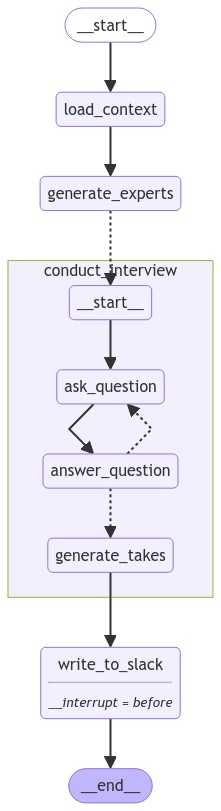

In [6]:
import sqlite3

import requests

from langgraph.constants import Send
from langgraph.checkpoint.sqlite import SqliteSaver

def initiate_all_interviews(state: OverallState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    topic = state["topic"]
    return [Send("conduct_interview", {"topic": topic,
                                       "expert": expert}) for expert in state["experts"]]

def write_to_slack(state: OverallState):
    """ Write the report to external service (Slack) """
    
    # Full set of interview reports
    takes = state["takes"]

    # Write to your Slack Channel via webhook
    true = True
    headers = {
        'Content-Type': 'application/json',
    }

    # Write to slack
    for t in takes:
        for take in t.takes:
            
            # Blocks
            blocks = []
            
            # Block 1: Title section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*{take.title}*"
                }
            })
            
            # Block 2: Divider
            blocks.append({
                "type": "divider"
            })
            
            # Block 3: Content section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"{take.take}"
                }
            })
    
            blocks.insert(0, {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": ":fire: :robot_face: Take-Bot is heating up ...",
                    "emoji": true
                }
            })
            
            data = {
                "blocks": blocks,
            }
            
            response = requests.post(slack_bot_url, headers=headers, json=data)
        
# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("load_context", load_context)
overall_builder.add_node("generate_experts", generate_experts)
overall_builder.add_node("conduct_interview", interview_builder.compile())
overall_builder.add_node("write_to_slack",write_to_slack)

overall_builder.add_edge(START, "load_context")
overall_builder.add_edge("load_context", "generate_experts")
overall_builder.add_conditional_edges("generate_experts", initiate_all_interviews, ["conduct_interview"])
overall_builder.add_edge("conduct_interview", "write_to_slack")
overall_builder.add_edge("write_to_slack", END)

# Memory
db_path = "state_db/final_assistant.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

# Compile
graph = overall_builder.compile(checkpointer=memory,interrupt_before=['write_to_slack'])

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
thread = {"configurable": {"thread_id": "111"}}
topic = "Interesting players and draft stratefies for QB, RB, WR, and TE in Fantasy Football."
result = graph.invoke({"topic": topic}, thread)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


We can review the takes. 

In [10]:
from IPython.display import Markdown, display
state = graph.get_state(thread)
for interview_takes in state.values['takes']:
    for take in interview_takes.takes:
        display(Markdown(f"### {take.title}\n{take.take}\n"))

### Reach for Your QB Beliefs!
When drafting quarterbacks, don't be overly concerned with ADP after the initial rounds. If there's a QB you believe in, draft them ahead of their ADP to build a roster you're excited about. This strategy is especially effective if you draft at the turn.


### ADP Loses Relevance Quickly
By Week 3, initial draft positions become less relevant. Focus on the performance and potential of players on your roster rather than strictly adhering to ADP rankings.


### Late-Round RB Sleepers to Watch
Keep an eye on running backs like Davis, Vidal, and Iosivas. These under-the-radar players have the potential to be game-changers if given the opportunity.


### Swing for the Fences with Late-Round Picks
Use your late-round picks to take risks on players who might not have a high ADP but have the potential to break out. Thorough research can help you identify these hidden gems.


### Offensive System Matters for QBs
When drafting quarterbacks, consider the offensive system and supporting cast. A QB's fantasy value can be significantly impacted by the quality of their offensive line, the talent of their receivers, and the overall offensive scheme.


### Mid-Round QB Strategy
Many fantasy managers prefer to wait on drafting a quarterback until the middle rounds, opting to build a strong core of RBs and WRs first. Target QBs with high upside who are being drafted later due to perceived risks or less hype.


### Training Camp Insights
Keep an eye on training camp reports and preseason performances for QBs. These can provide valuable insights into how well a QB is meshing with their team and adapting to any changes in the offensive system.


### Kenneth Walker: Mid-Round Steal
Kenneth Walker is a potential mid-round steal. Despite concerns about other RBs being drafted ahead of him, Walker has an established role and is expected to benefit from a new offensive coordinator who loves him.


### Avoid Overhyped RBs
Be cautious of overhyped running backs with significant risks. Joe Mixon and Alvin Kamara are examples of players to avoid due to inefficiency, age, and reliance on short passes from their quarterbacks.


### Late-Round RB Fliers
Taking late-round fliers on RBs with a clear path to playing time can be a winning strategy. Chuba Hubbard and Chase Brown are examples of late-round picks that could pay off big.


### Injury Considerations for RBs
Monitor injury reports and training camp news for RBs. Jonathan Brooks, currently drafted as RB24, might be a risky pick due to injury. Safer picks like Devin Singletary, going several rounds later, could be wiser choices.


### High-Upside Handcuffs
Drafting high-upside handcuffs can be smart. Backup RBs like Tyjae Spears and Javonte Williams could become starters if the primary RB gets injured, offering significant fantasy value.


### QB Rankings Shake-Up: Herbert and Purdy on the Rise
Justin Herbert has jumped from 189 to 119 in ESPN's rankings, making him a valuable pick if you can snag him at the right spot. Brock Purdy's rise from 140 to 93 also makes him a sleeper to watch.


### Anthony Richardson: A Risky Yet Tempting Fall
Anthony Richardson's drop from 44 to 58 in the rankings might make him a more attractive option for those willing to gamble on high upside.


### Nick Chubb's Injury Opens Door for Jerome Ford
With Nick Chubb expected to miss the first four games, Jerome Ford becomes a potential steal in the mid to late rounds, especially for zero RB strategists.


### Rhamondre Stevenson and Aaron Jones: Value Picks?
Rhamondre Stevenson and Aaron Jones have both dropped in ESPN's rankings, making them potentially valuable picks if they fall to you at the right spot.


### Chuba Hubbard: Sleeper Alert!
Chuba Hubbard's significant rise from 173 to 115 in the rankings suggests he could be a sleeper pick worth considering in your draft.


Now, let's confirm the next node to call.

In [11]:
print(state.next)

('write_to_slack',)


Now, let's write to Slack.

In [12]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

We cam look at the trace:

https://smith.langchain.com/public/e05c3a33-6c10-43b0-94a6-77adca72954f/r

We can also see the results written to Slack:

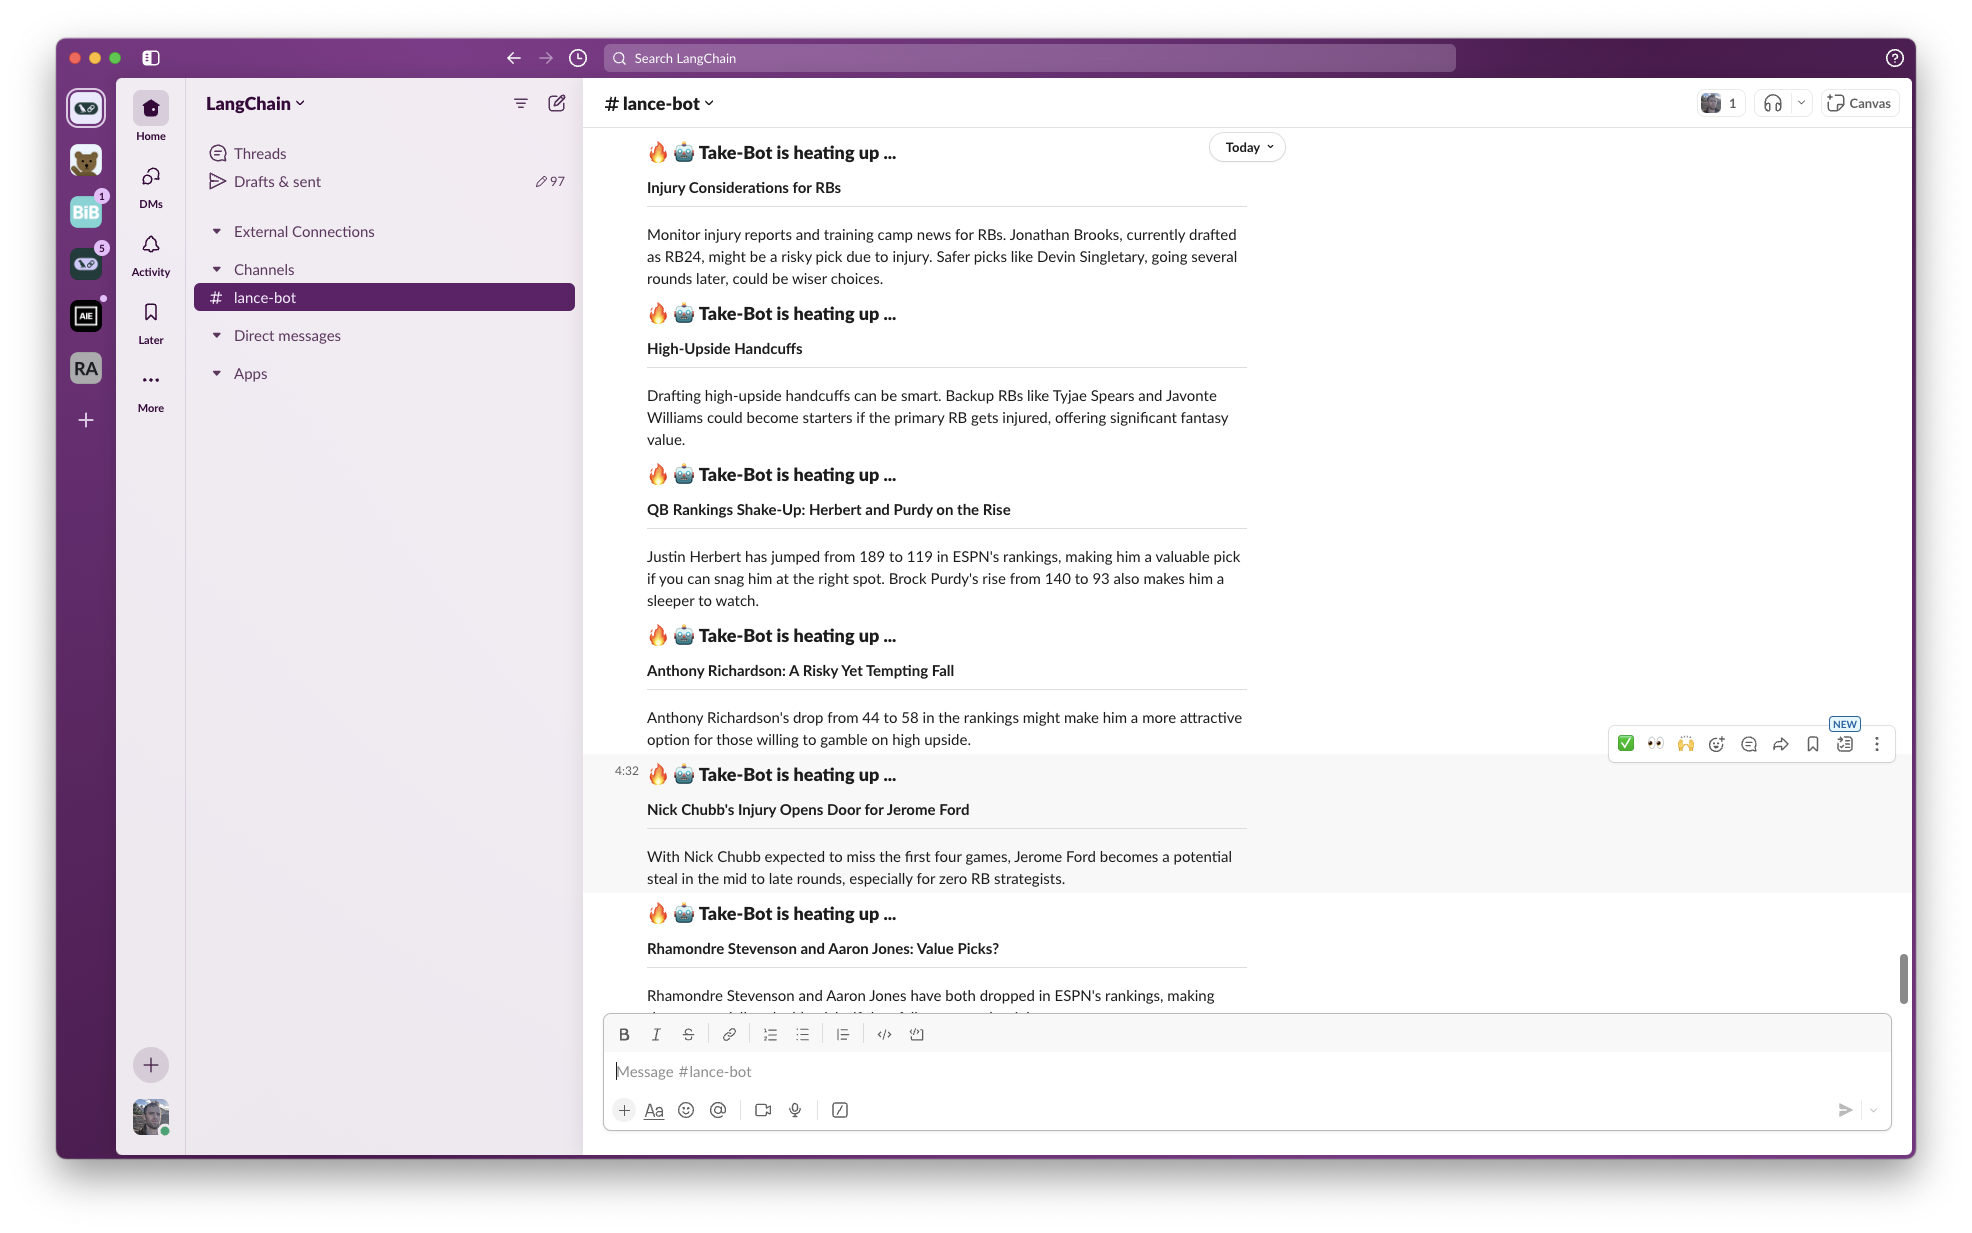